# Efficiency Solutions for Heavy Industry

### Task statement
Prepare a prototype of a machine learnin
g model for the company develops efficiency solutions for heavy industry. The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification. The model will help to optimize the production and eliminate unprofitable parameters.

### Technological Process
Mined ore undergoes primary processing to get the ore mixture or rougher feed, which is the raw material for flotation (also known as the rougher process). After flotation, the material is sent to two-stage purification.
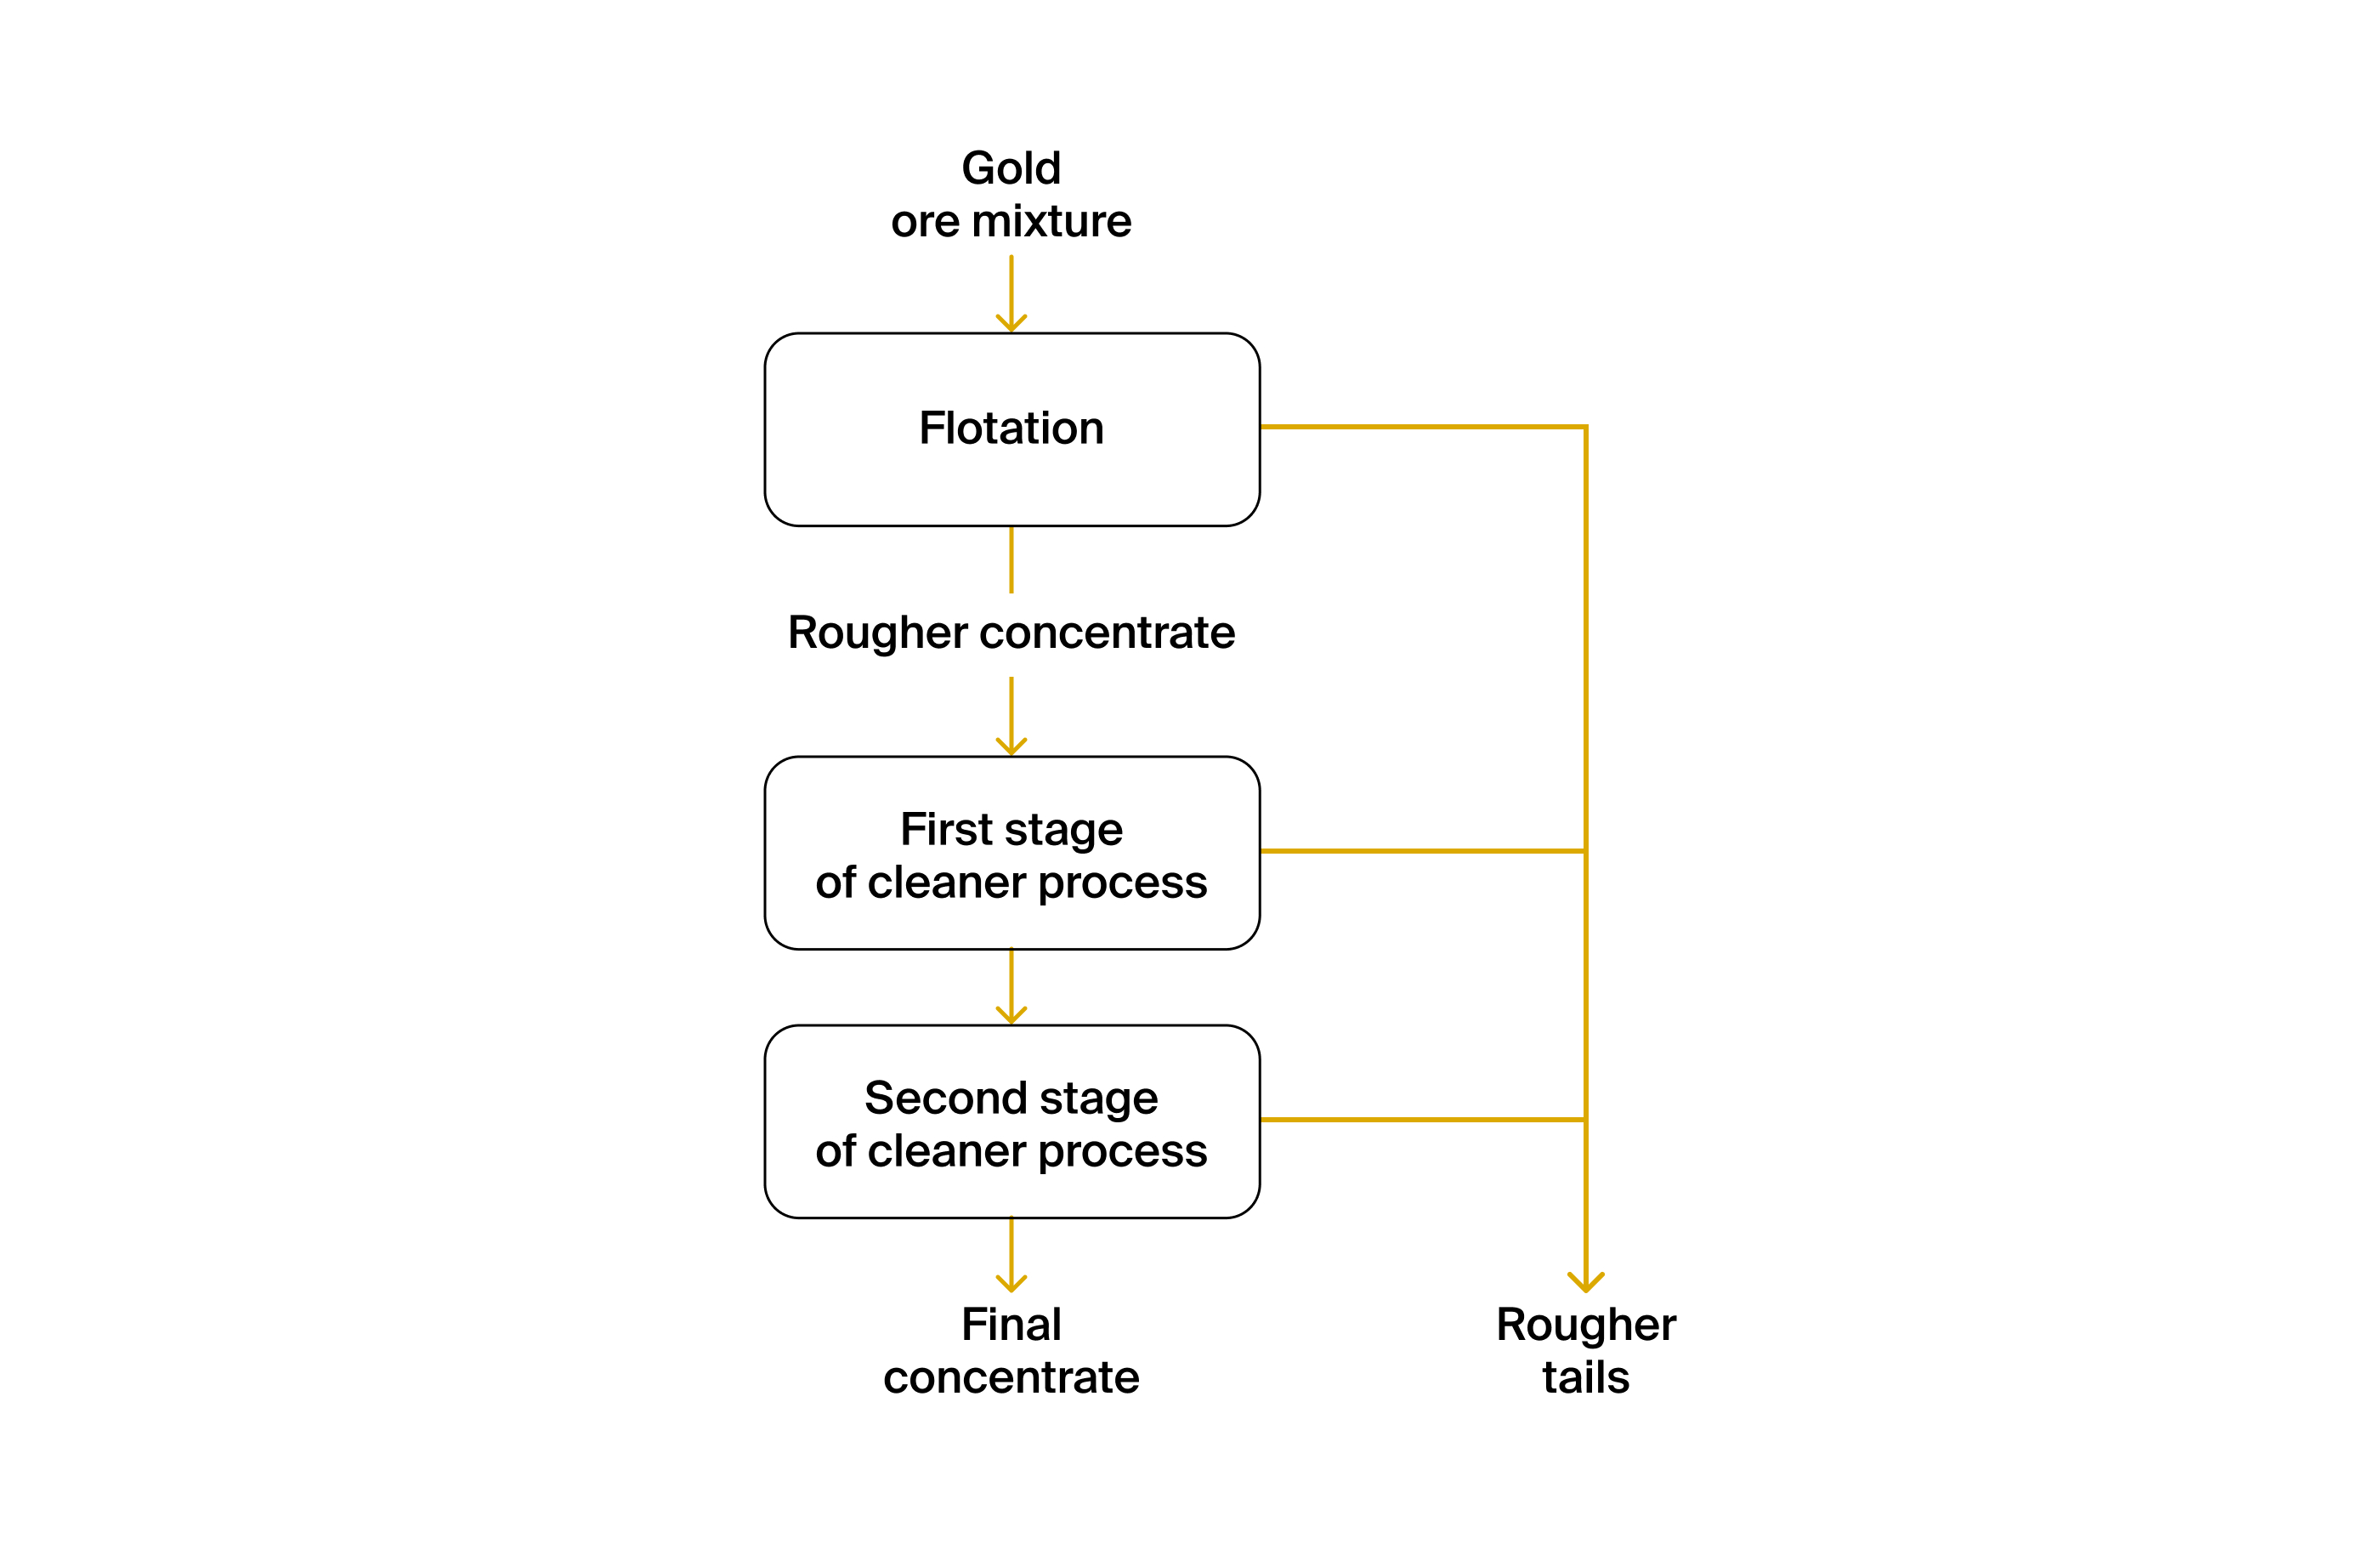

1. <b>Flotation</b>

Gold ore mixture is fed into the float banks to obtain rougher Au concentrate and rougher tails (product residues with a low concentration of valuable metals).
The stability of this process is affected by the volatile and non-optimal physicochemical state of the flotation pulp (a mixture of solid particles and liquid).

2. <b>Purification</b>

The rougher concentrate undergoes two stages of purification. After purification, we have the final concentrate and new tails.
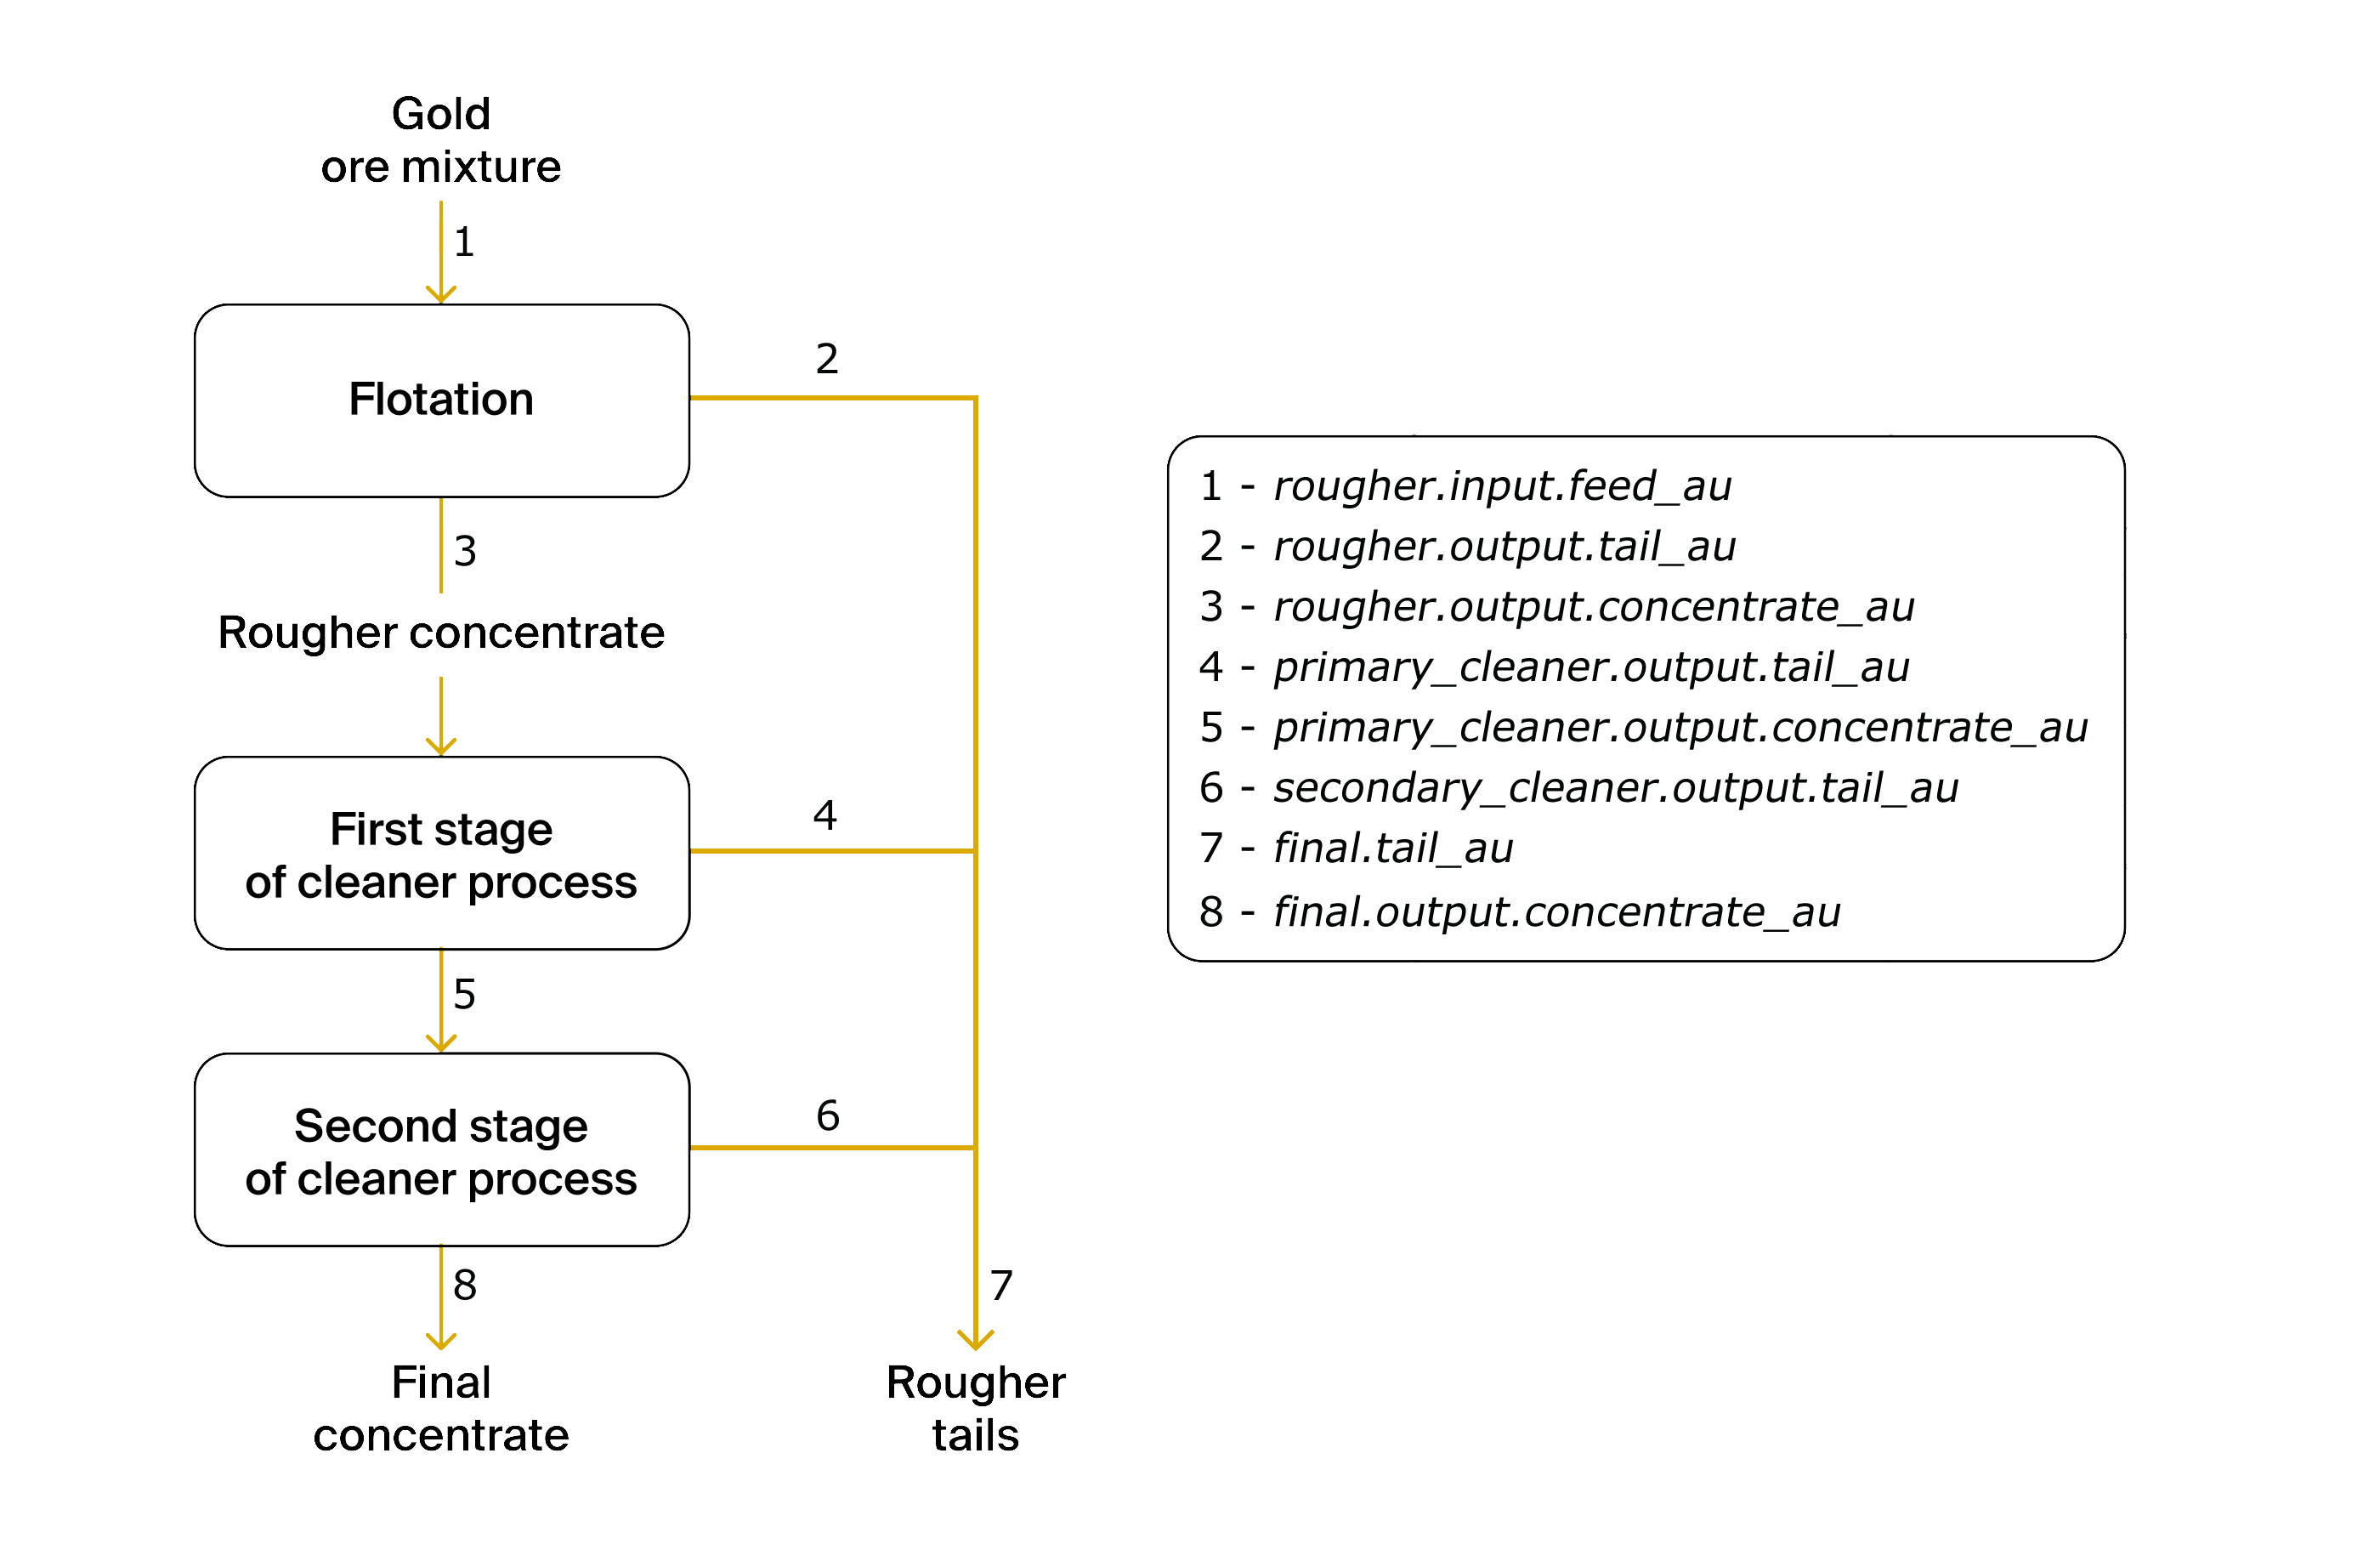

### Recovery calculation
You need to simulate the process of recovering gold from gold ore.
Use the following formula to simulate the recovery process:
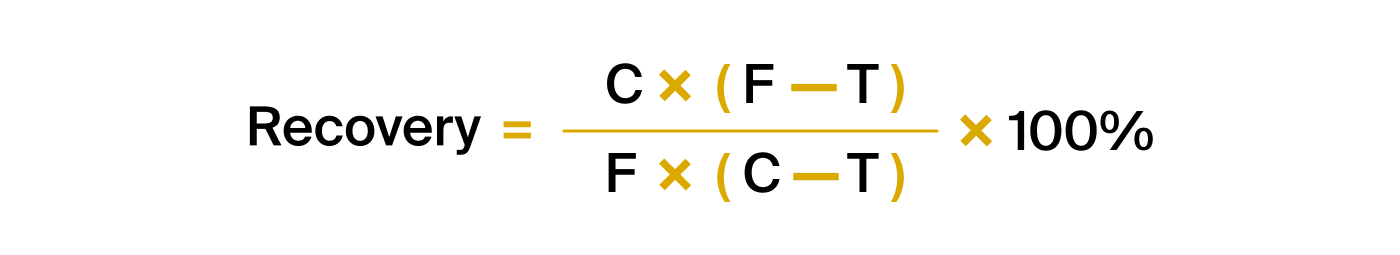
where:
- C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
- F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
- T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

To predict the coefficient, you need to find the share of gold in the concentrate and the tails. Note that both final and rougher concentrates matter.

### Evaluation metric
To solve the problem, we will need a new metric. It is called $sMAPE$, symmetric Mean Absolute Percentage Error.
It is similar to MAE, but is expressed in relative values instead of absolute ones. Why is it symmetrical? It equally takes into account the scale of both the target and the prediction.
Here’s how $sMAPE$ is calculated:
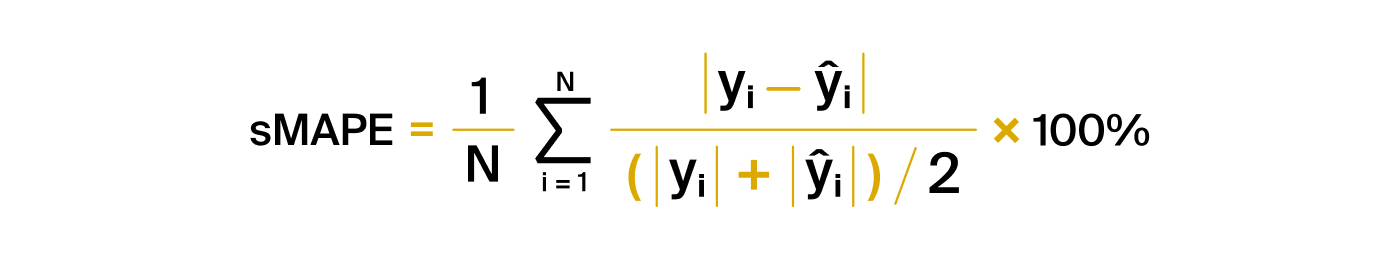
Denotation:
- $y_i$ - value of target for the observation with the i index in the sample used to measure quality.
- $\hat{y_i}$ - value of prediction for the observation with the i index, for example, in the test sample.
- $N$ - number of observations in the sample.
- $\sum_{i=1}^N$ - summation over all observations of the sample (i takes values from 1 to N).

We need to predict two values:
- rougher concentrate recovery ```rougher.output.recovery```
- final concentrate recovery ```final.output.recovery```

The final metric includes the two values:

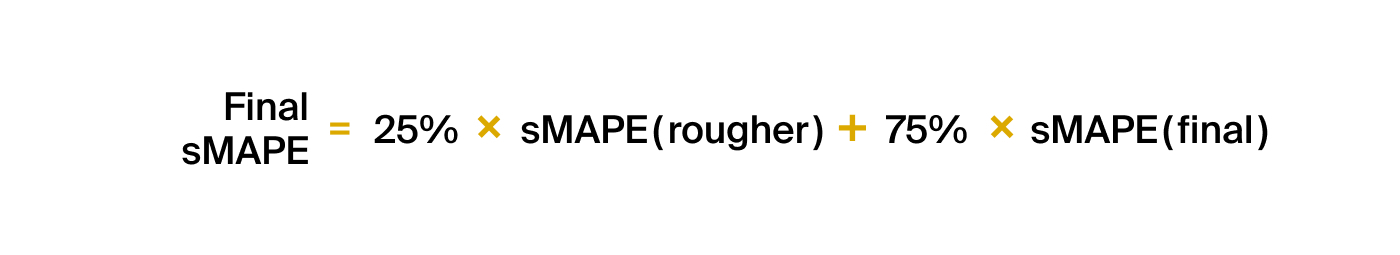

##  Prepare the data

In [1]:
!pip install -U sidetable

In [2]:
# Loading all the libraries
import pandas as pd
import numpy as np
import sidetable
import warnings
import sys
from sklearn.pipeline import Pipeline
from numpy.random import RandomState
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt


In [3]:
# Load the data files into different DataFrames
# to try to open a data file
try:
    train = pd.read_csv('/datasets/gold_recovery_train.csv')
    test = pd.read_csv('/datasets/gold_recovery_test.csv')
    data = pd.read_csv('/datasets/gold_recovery_full.csv')
except:
    pritrainnt('Unable to open the files')

In [4]:
# Shapes of datasets
print(data.shape)
print(train.shape)
print(test.shape)
print(len(train)/len(data)*100)
print(len(test)/len(data)*100)

(22716, 87)
(16860, 87)
(5856, 53)
74.22081352350766
25.779186476492338


In [5]:
# description of the full dataset
print(data.info())
#print(data.describe())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [6]:
# description of the train dataset
print(train.info())
#print(train.describe())
#train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [7]:
# description of the test dataset
print(test.info())
#print(test.describe())
#test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [8]:
# difference of columns between train and test sets
train_test_columns = list(set(train)-set(test))
print(len(train_test_columns))
train_test_columns

34


['final.output.concentrate_au',
 'primary_cleaner.output.concentrate_sol',
 'rougher.output.concentrate_pb',
 'rougher.output.recovery',
 'primary_cleaner.output.concentrate_au',
 'final.output.tail_ag',
 'primary_cleaner.output.concentrate_ag',
 'rougher.output.tail_pb',
 'final.output.recovery',
 'rougher.calculation.au_pb_ratio',
 'secondary_cleaner.output.tail_ag',
 'primary_cleaner.output.concentrate_pb',
 'secondary_cleaner.output.tail_pb',
 'final.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'final.output.tail_au',
 'primary_cleaner.output.tail_sol',
 'final.output.concentrate_sol',
 'secondary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'rougher.output.concentrate_sol',
 'final.output.concentrate_ag',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'secondary_cleaner.output.tail_sol',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.output.tail_ag',
 'rougher.calculation.sulfate_to_au_concentrate',
 'final.output.tail_sol',
 'rou

In [9]:
# calculate recovery
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']
train['recovery'] = (C*(F-T))/(F*(C-T))*100

In [10]:
#
train[['rougher.output.recovery','recovery']]

,rougher.output.recovery,recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
16855,89.574376,89.574376
16856,87.724007,87.724007
16857,88.890579,88.890579
16858,89.858126,89.858126


In [12]:
# the number and percentage of missing values in the train dataset
train.stb.missing(style=True)

,missing,total,percent
rougher.output.recovery,"2,573","16,860",15.26%
recovery,"2,283","16,860",13.54%
rougher.output.tail_ag,"2,250","16,860",13.35%
rougher.output.tail_au,"2,249","16,860",13.34%
rougher.output.tail_sol,"2,249","16,860",13.34%
secondary_cleaner.output.tail_sol,"1,986","16,860",11.78%
rougher.input.floatbank11_xanthate,"1,904","16,860",11.29%
final.output.recovery,"1,521","16,860",9.02%
primary_cleaner.input.sulfate,"1,307","16,860",7.75%
primary_cleaner.input.depressant,"1,262","16,860",7.49%


In [13]:
# the number and percentage of missing values in the full dataset
data.stb.missing(style=True)

,missing,total,percent
rougher.output.recovery,"3,119","22,716",13.73%
rougher.output.tail_ag,"2,737","22,716",12.05%
rougher.output.tail_au,"2,736","22,716",12.04%
rougher.output.tail_sol,"2,736","22,716",12.04%
rougher.input.floatbank11_xanthate,"2,257","22,716",9.94%
secondary_cleaner.output.tail_sol,"2,215","22,716",9.75%
final.output.recovery,"1,963","22,716",8.64%
rougher.calculation.au_pb_ratio,"1,627","22,716",7.16%
primary_cleaner.input.sulfate,"1,609","22,716",7.08%
primary_cleaner.input.depressant,"1,546","22,716",6.81%


In [14]:
# to make the values in the "date" column a datetime data type
data['date'] =  pd.to_datetime(data['date'],format = '%Y-%m-%d')
train['date'] =  pd.to_datetime(train['date'],format = '%Y-%m-%d')
test['date'] =  pd.to_datetime(test['date'],format = '%Y-%m-%d')
train.tail()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,recovery
16855,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428,89.574376
16856,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608,87.724007
16857,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452,88.890579
16858,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,89.858126
16859,2018-08-18 10:59:59,3.598375,11.737832,6.717509,46.299438,70.281454,8.406690,2.517518,10.652193,1.389434,...,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575,89.514960


In [16]:
# the number and percentage of missing values in the train dataset
train.stb.missing(style=True)

,missing,total,percent
rougher.output.recovery,"2,573","16,860",15.26%
recovery,"2,283","16,860",13.54%
rougher.output.tail_ag,"2,250","16,860",13.35%
rougher.output.tail_au,"2,249","16,860",13.34%
rougher.output.tail_sol,"2,249","16,860",13.34%
secondary_cleaner.output.tail_sol,"1,986","16,860",11.78%
rougher.input.floatbank11_xanthate,"1,904","16,860",11.29%
final.output.recovery,"1,521","16,860",9.02%
primary_cleaner.input.sulfate,"1,307","16,860",7.75%
primary_cleaner.input.depressant,"1,262","16,860",7.49%


In [17]:
train.duplicated().sum()

0

In [18]:
warnings.filterwarnings("ignore")
print(sorted(train['recovery'].unique()))

[-366924.16128978424, -112789.87330125556, -3913.3128659839563, -488.9934893739163, -213.38719973833324, -126.15685783870576, -116.31211751431452, -114.53692666822715, -78.43480379975492, -47.48657995229352, -45.91166555849696, -29.184589506986413, -28.330623434001257, -18.098131817159828, -15.201068252032709, -9.003588834479071, -1.0861852911085985, -0.0, 1.412748333296538, 4.323053913797493, 9.82687608019416, 13.708197146714943, 17.5664558572139, 22.463083587451283, 23.751304979477148, 26.275907592401865, 27.727541833159684, 30.701255590461233, 31.711542556648244, 34.915704136584466, 37.97956439652615, 38.337949137813176, 38.39079385900252, 39.015183438776596, 39.1966030116469, 40.34670966308227, 41.89961609095374, 42.918890531167115, 43.89456892055666, 44.27186238511162, 45.26879134617812, 45.546462553699186, 45.87522019946764, 46.68188859416204, 46.69867383975437, 46.95121267715536, 48.218564287164426, 48.420327023904456, 48.45773424761837, 49.05565298748501, 49.443261484556466, 50

In [20]:
# calculation mean absolute error (MAE)
mae = (abs(train['recovery'] - train['rougher.output.recovery'])).sum()/len(train['rougher.output.recovery'])
print(mae)

9.312367649051928e-15


In [19]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train = train.dropna(subset=['recovery','rougher.output.recovery'])
train.shape

(14287, 88)

In [21]:
# fill in the missing values in the dataset with the nearest below
train.sort_values('date',inplace = True)
data = data.fillna(method='ffill')
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')

### Conclusion
The data is divided into a training and test set 3:1. The full and training sets have 87 columns, the test set has only 53, this dataset does not contain data on tails, cleaning and concentration of elements at each stage. The missing values in the data have been replaced with the nearest known ones sorted by date and time. The calculated "Recovery" did not show significant differences, the mean absolute error (MAE) is also close to zero, so we can accept "rougher.output.recovery" without changes.

## Analyze the data

In [22]:
# data containing values about the metal and stage
metals = ['au','ag','pb']
stages = ['rougher.input.feed_','primary_cleaner.output.concentrate_',
          'rougher.output.concentrate_','final.output.concentrate_']

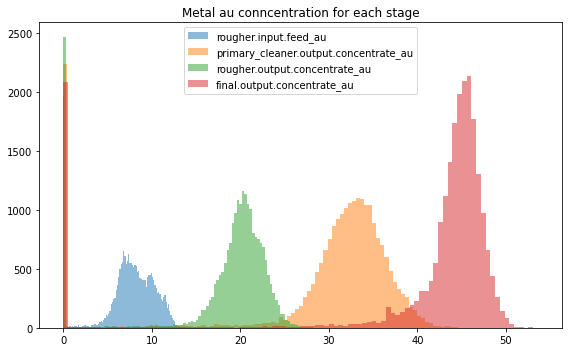

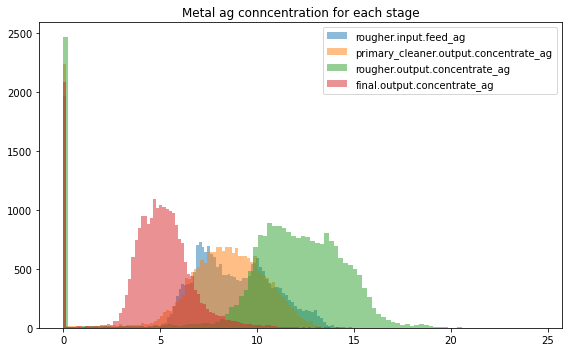

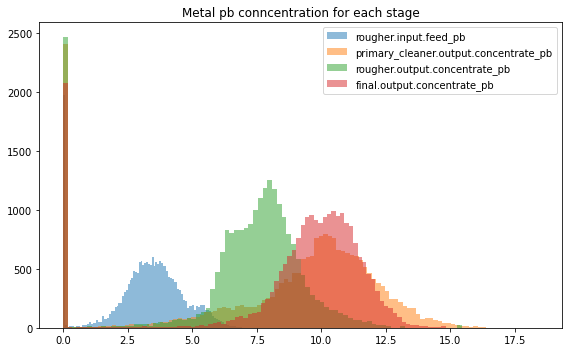

In [23]:
# histograms describing conncentration of metal for each stage
for metal in metals:
    fig = plt.subplots(figsize=(8, 5))
    for stage in stages:
        plt.hist(data[stage+metal], bins=100, label=stage+metal, alpha = .5)
    plt.title('Metal '+metal+' conncentration for each stage')
    plt.legend()
    plt.tight_layout()
    plt.show()

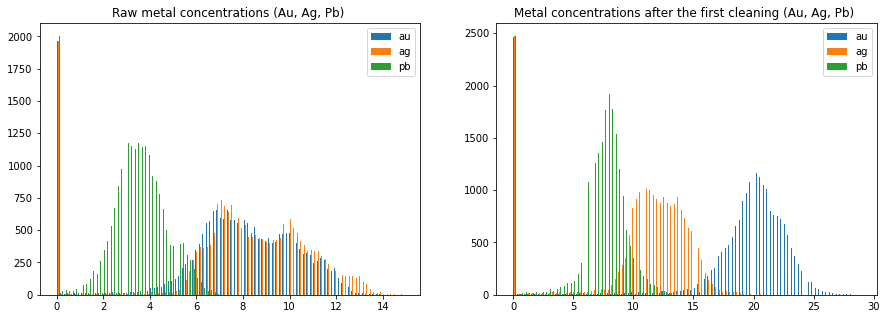

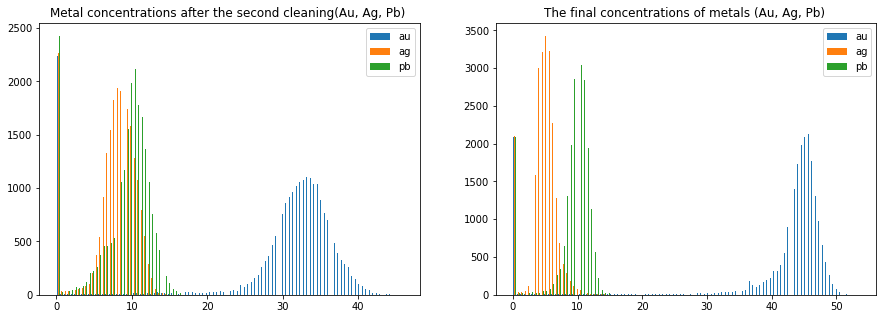

In [24]:
# Raw material
feed = ['rougher.input.feed_au','rougher.input.feed_ag','rougher.input.feed_pb']
# Rougher output after first stage of cleaner process
primary = ['rougher.output.concentrate_au','rougher.output.concentrate_ag','rougher.output.concentrate_pb']
# Rougher output after second stage of cleaner process
secondary = ['primary_cleaner.output.concentrate_au','primary_cleaner.output.concentrate_ag','primary_cleaner.output.concentrate_pb']
# Final output
final = ['final.output.concentrate_au','final.output.concentrate_ag','final.output.concentrate_pb']

# histograms describing the metal content at different stages
fig, ax = plt.subplots(1,2)
ax[0].hist(data[feed],bins=100,label=metals)
ax[0].set_title('Raw metal concentrations (Au, Ag, Pb) ')
ax[0].legend()
ax[1].hist(data[primary],bins=100,label=metals)
ax[1].set_title('Metal concentrations after the first cleaning (Au, Ag, Pb) ')
ax[1].legend()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.show()
fig, ax = plt.subplots(1,2)
ax[0].hist(data[secondary],bins=100,label=metals)
ax[0].set_title('Metal concentrations after the second cleaning(Au, Ag, Pb) ')
ax[0].legend()
ax[1].hist(data[final],bins=100,label=metals)
ax[1].set_title('The final concentrations of metals (Au, Ag, Pb) ')
ax[1].legend()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.show()


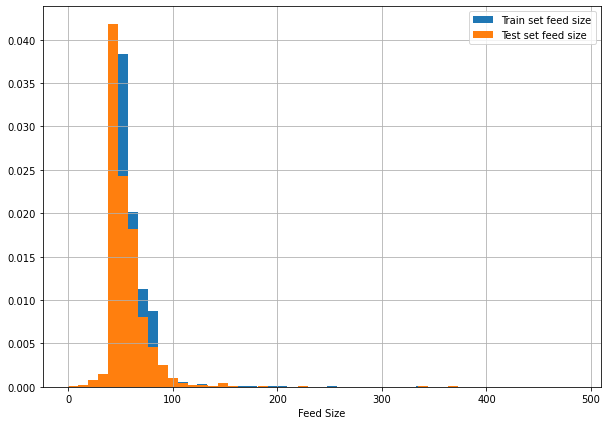

In [25]:
# the feed particle size distributions in the training set and in the test set
train['rougher.input.feed_size'].hist(bins=50, label='Train set feed size',density=True,figsize= (10,7))
test['rougher.input.feed_size'].hist(bins=50, label='Test set feed size',density=True,figsize= (10,7))
plt.legend()
plt.xlabel('Feed Size')
plt.show()

In [26]:
warnings.filterwarnings("ignore")
# calculate the concentration of elements at each stage
train['feed_concentrate'] = train[feed].sum(axis=1)
train['rougher_concentrate'] = train[primary].sum(axis=1)
train['final_concentrate'] = train[final].sum(axis=1)
test['feed_concentrate'] = test[feed].sum(axis=1)

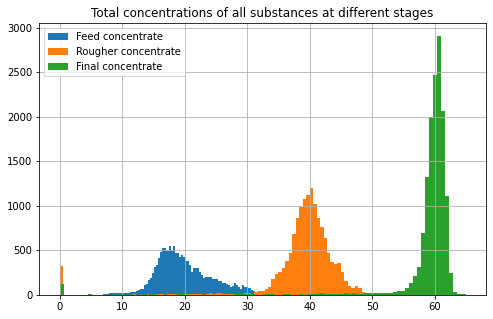

In [27]:

train['feed_concentrate'].hist(bins=100, label='Feed concentrate',figsize=(8, 5))
train['rougher_concentrate'].hist(bins=100, label='Rougher concentrate',figsize=(8, 5))
train['final_concentrate'].hist(bins=100, label='Final concentrate',figsize=(8, 5))
plt.legend()
plt.title('Total concentrations of all substances at different stages')
plt.show()

In [28]:
# find the lower limits of outliers

def lower_limit(df):
    
    # calculate Q1 and Q3 
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # calculate IQR
    IQR = Q3 - Q1
    
    # calculate lower bound for outliers 
    outlier_lower = Q3 - 1.5*IQR

    return outlier_lower


In [29]:
# exclude outliers from datasets
train = train[train['feed_concentrate'] > lower_limit(train['feed_concentrate'])]
print(len(test[test['feed_concentrate'] < lower_limit(test['feed_concentrate'])]))
test = test[test['feed_concentrate'] > lower_limit(test['feed_concentrate'])]
print(train.shape)
print(test.shape)


625
(13545, 91)
(5231, 54)


### Conclusion
Histograms of all stages of gold extraction from ore were constructed. Separate histograms for the three elements Au, Ag, Pb showed that the main raw materials and ore mixture after each stage contain abnormal values. The total concentrations of all substances at different stages also contain abnormal values. To get rid of outliers, the lower limit of the interquartile range (IQR) was calculated. According to the graph of the distribution of feed particles in the train and test datasets, it is clear that the distributions are very similar, which means that the evaluation of the constructed model will be correct.


## Build the model

In [30]:
#Add features and target columns to test set
test = pd.merge(test, data[['date', 'final.output.recovery', 'rougher.output.recovery']], on='date', how='left')
test.shape

(5231, 56)

In [31]:
#Remove outcome columns from train set
train = train.loc[: ,test.columns]
train.shape

(13545, 56)

In [32]:
# Features and target
features_train = train.drop(columns=['rougher.output.recovery', 'final.output.recovery', 'date']).values
target_train = train[['rougher.output.recovery', 'final.output.recovery']].values

features_test = test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis = 1).values
target_test = test[['rougher.output.recovery', 'final.output.recovery']].values


In [34]:
# a function to calculate sMAPE and final sMAPE value
def smape(test, predict):
    return (np.abs(test - predict)/((np.abs(test) + np.abs(predict))/2)).mean()

def final_smape(test, predict):
    rougher = smape(test[:,0], predict[:,0])
    final = smape(test[:,1], predict[:,1])
    return ((0.25 * rougher) + (0.75 * final))

 

In [34]:
# a function to calculate sMAPE and final sMAPE value
def smape(test, predict):
    return (np.abs(test - predict)/((np.abs(test) + np.abs(predict))/2)).mean()

def final_smape(test, predict):
    rougher = smape(test[:,0], predict[:,0])
    final = smape(test[:,1], predict[:,1])
    return ((0.25 * rougher) + (0.75 * final))

 

In [34]:
# a function to calculate sMAPE and final sMAPE value
def smape(test, predict):
    return (np.abs(test - predict)/((np.abs(test) + np.abs(predict))/2)).mean()

def final_smape(test, predict):
    rougher = smape(test[:,0], predict[:,0])
    final = smape(test[:,1], predict[:,1])
    return ((0.25 * rougher) + (0.75 * final))

 

In [35]:
#Create scorer 
smape_scorer = make_scorer(final_smape)

### Dummy Regressor

In [36]:
# training the model with a dummy regressor 
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy_regr_test_predict = dummy_regr.predict(features_test)

# evaluate baseline model
final_smape(target_test, dummy_regr_test_predict)

0.10457180143992738

### Linear Regression

In [37]:
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('modelling', LinearRegression())
])
pipe.fit(features_train, target_train)

preds = pipe.predict(features_test)

print(cross_val_score(pipe,features_train, target_train, cv=5,scoring = smape_scorer))

print(final_smape(target_test, preds))

[0.15082527 0.10363123 0.1355909  0.11378173 0.11716939]
0.10194078627761509


### Decision Trees

In [38]:
# finding the optimal depth of the decision tree

for depth in range(1,7,1):
    pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('modelling', DecisionTreeRegressor(random_state=12345, max_depth=depth))])
    #model_tree_reg = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    pipe.fit(features_train, target_train)
    print('max_depth =',depth, ':',end= '')
    print(cross_val_score(pipe,features_test,target_test, cv=5,scoring = smape_scorer).mean())

max_depth = 1 :0.10334314073725932
max_depth = 2 :0.1047435267136259
max_depth = 3 :0.11003254719801077
max_depth = 4 :nan
max_depth = 5 :nan
max_depth = 6 :nan


In [39]:
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('modelling', DecisionTreeRegressor(random_state=12345, max_depth = 3))
])
pipe.fit(features_train, target_train)

preds = pipe.predict(features_test)

print(cross_val_score(pipe,features_train, target_train, cv=5,scoring = smape_scorer))

print(final_smape(target_test, preds))

[0.09959233 0.09824996 0.12851183 0.12736844 0.10370252]
0.09854469090056567


### Random Forest

In [40]:
%%time
# finding the optimal depth in a random forest model

for depth in range(1, 4, 1):
    #model_forest_reg = RandomForestRegressor(random_state=12345, max_depth=depth)
    pipe = Pipeline([('scaling', StandardScaler()),
    ('modelling', RandomForestRegressor(random_state=12345, max_depth=depth))])
    pipe.fit(features_train, target_train)
    print('max_depth = ', depth,':', end= '')
    print(cross_val_score(pipe,features_train, target_train,cv=5,scoring = smape_scorer).mean())

max_depth =  1 :0.11432762878453573
max_depth =  2 :0.11024915291094539
max_depth =  3 :0.10631003650896283
Wall time: 1min 54s


In [41]:
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('modelling', RandomForestRegressor(random_state=12345, max_depth = 1))
])
pipe.fit(features_train, target_train)

preds = pipe.predict(features_test)

print(cross_val_score(pipe,features_train, target_train, cv=5,scoring = smape_scorer))

print(final_smape(target_test, preds))

[0.10432868 0.10133906 0.12486435 0.13428669 0.10681936]
0.09622414098472952


## Conclusion
The train and test dataset were aligned according to the set of features. Data was scaled using Standard Scaler. Data training was carried out by Linear Regression algorithms, a Decision Tree and a Random Forest. For the last two algorithms, the parameters were adjusted.  Each model is evaluated using cross-validation. The final value was calculated the sMAPE(symmetric mean absolute percentage error). 

Comparing the results of the evaluation metric, the best percentage was shown by a model based on a Decision Tree. This model will help optimize production and eliminate unprofitable parameters.

In [42]:
#Function to train model using GridSearchSV 
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

def best_model (model, parm):
    model = GridSearchCV(model, parm, cv=5, verbose=0, refit=True, scoring=smape_scorer)
    model.fit(features_train, target_train)
    print('Score:',abs(model.best_score_))
    print('Parameters:',model.best_params_)
    return abs(model.best_score_)

lin_regression = best_model(LinearRegression(), {})

decision_tree = best_model(DecisionTreeRegressor(random_state=12345), 
                           {'max_depth':range(1,5)})

forest_regression = best_model(RandomForestRegressor(random_state=12345), {
                        'n_estimators' : range(10, 100, 20),
                        'max_depth' : range(1,4,1)})


Score: 0.12401637883891317
Parameters: {}
Score: 0.11645848191563424
Parameters: {'max_depth': 1}
Score: 0.11441460755401209
Parameters: {'max_depth': 1, 'n_estimators': 90}
